Faisant suite au document présentant l'usage de la LSI et LDA, nous proposons ici de constituer des groupes de tweets rapprochés par similarité du point vue sémantique.
Nous partons d'un corpus d'alertes constitué cette fois automatiquement par une requête elasticsearch filtrant sur une terminologie appropriée toujours sur la journée du 17 avril 2015.
Ce document adapte le post http://sujitpal.blogspot.fr/2014/08/topic-modeling-with-gensim-over-past.html au contexte des tweets d'alertes.

Constitution du dictionnaire et vectorisation du corpus comme dans le document précédent

In [3]:
import logging
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
from itertools import chain
from gensim import utils
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from codecs import open
%matplotlib inline

stop_word_list = stopwords.words('french')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from gensim import corpora, models, similarities

data_dir='/infres/ir430/bd/stif/PYTHON/PRES_9_MARS/'

In [4]:
def emoji_remove(word):
    try:
        # Wide UCS-4 build
        myre = re.compile(u'['
            u'\U0001F300-\U0001F64F'
            u'\U0001F680-\U0001F6FF'
            u'\u2600-\u26FF\u2700-\u27BF]+', 
            re.UNICODE)
    except re.error:
        # Narrow UCS-2 build
        myre = re.compile(u'('
            u'\ud83c[\udf00-\udfff]|'
            u'\ud83d[\udc00-\ude4f\ude80-\udeff]|'
            u'[\u2600-\u26FF\u2700-\u27BF])+', 
            re.UNICODE)
    return(myre.sub('', word))
def transform_line(line):
    tokens = [word for word in [emoji_remove(re.sub(r'[\\".,?!:;()\[\]\{\}/]' , "", word) ) 
                            for word in chain.from_iterable([regexp_tokenizer.tokenize(word) 
                                                             for word in tweet_tokenizer.tokenize(line.lower())]) 
                            if word not in stop_word_list] 
          if len(word)>0]
    return tokens

infilename = data_dir +'alerts.out'
with open(infilename, 'r',encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()

tweet_tokenizer = TweetTokenizer()
regexp_tokenizer = RegexpTokenizer('[^\']+')

texts = [ transform_line(line) for line in lines ]

dictionary = corpora.Dictionary(texts)
dictionary.save(data_dir +'alerts.dict')
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(data_dir +'alerts.mm', corpus)

On décide de réduire l'espace à 2 dimensions afin de clustériser et de pouvoir en constater visuellement le résultat. 

In [6]:
tfidf = models.TfidfModel(corpus,normalize=True)
corpus_tfidf = tfidf[corpus]
lsi =  models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
corpus_lsi=lsi[corpus_tfidf]
fcoords = open(os.path.join(data_dir,"coords.csv"),'wb')
for  vector in corpus_lsi:
    if len(vector) != 2:
        continue
    text = "%6.4f\t%6.4f\n" % (vector[0][1],vector[1][1])
    fcoords.write(text)
fcoords.close()

On utilise l'algorithme K-Means de sklearn pour partitionner les points. On fait varier le nombre de clusters de 1 à 10 en sauvegardant à chaque étape les inerties calculées par l'algorithme. On affiche ensuite la courbe de cette inertie en fonction du nombre de clusters. Le nombre de clusters est sélectionné par la technique du elbow point http://www.analyticbridge.com/profiles/blogs/identifying-the-number-of-clusters-finally-a-solution

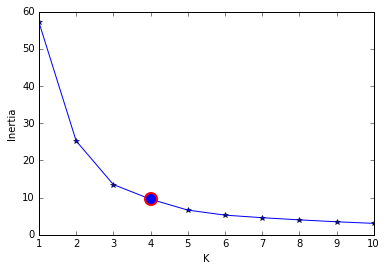

In [7]:
MAX_K=10

X = np.loadtxt(os.path.join(data_dir,"coords.csv"), delimiter="\t")
ks = range(1,MAX_K+1)
inertias = np.zeros(MAX_K)
diff = np.zeros(MAX_K)
diff2 = np.zeros(MAX_K)
diff3 = np.zeros(MAX_K)
for k in ks:
    kmeans = KMeans(k).fit(X)
    inertias[k - 1] = kmeans.inertia_
    # first difference
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

elbow = np.argmin(diff3[3:]) + 3

plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")

Affichage des clusters

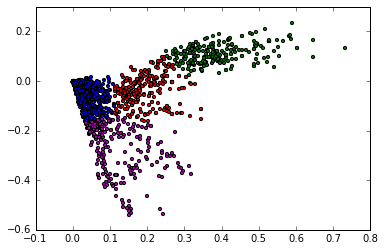

In [8]:
NUM_TOPICS = elbow + 1
kmeans = KMeans(NUM_TOPICS).fit(X)
y = kmeans.labels_

colors = ["b", "g", "r", "m"]
for i in range(X.shape[0]):
    plt.scatter(X[i][0], X[i][1], c=colors[y[i]], s=10)
plt.show()

Maintenant qu'on a une estimation du nombre de clusters, on utilise l'analyse LDA pour visualiser les concepts associés à chaque cluster

In [9]:
print(kmeans.labels_)

[3 3 3 ..., 1 3 1]


In [10]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS)
final_topics = lda.print_topics(NUM_TOPICS)

In [11]:
for line in final_topics:
    scores = [float(x.split("*")[0]) for x in line[1].split(" + ")]
    words = [x.split("*")[1] for x in line[1].split(" + ")]
    print (scores)
    print (words)

[0.023, 0.022, 0.02, 0.018, 0.016, 0.015, 0.014, 0.013, 0.012, 0.011]
[u'courant', u'rer', u'a', u'les', u'rt', u'b', u'trafic', u'nord', u'#rerb', u'incendie']
[0.03, 0.019, 0.018, 0.018, 0.018, 0.016, 0.016, 0.015, 0.015, 0.015]
[u'les', u'rer', u'sens', u'incendie', u'b', u'coups', u'deux', u'#rerb', u'trafic', u'courneuve']
[0.039, 0.029, 0.026, 0.024, 0.021, 0.016, 0.015, 0.015, 0.015, 0.014]
[u'rer', u'incendie', u'les', u'b', u'courneuve', u'a', u'sens', u'trafic', u'courant', u'coups']
[0.035, 0.034, 0.034, 0.031, 0.026, 0.019, 0.016, 0.016, 0.016, 0.014]
[u'rer', u'b', u'incendie', u'trafic', u'a', u'courneuve', u'nord', u'rt', u'interrompu', u'paris']
